In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from miskibin import get_logger
from pathlib import Path
import networkx as nx

In [53]:
path = Path('trade.csv').resolve()
df = pd.read_csv(path)
# df drop nan
df = df.dropna()
# remove european union
df = df[~df['ReporterISO3'].str.contains('EU')]
# REMOVE rows where ISO3 contains ,
df = df[~df['ReporterISO3'].str.contains(',')]
df = df[~df['PartnerISO3'].str.contains(',')]
df.head()


,ReporterISO3,ProductCode,ReporterName,PartnerISO3,PartnerName,Year,TradeFlowName,TradeFlowCode,TradeValue in 1000 USD
0,AGO,300220,Angola,ARE,United Arab Emirates,2018,Import,5,164.320
1,AGO,300220,Angola,ARE,United Arab Emirates,2019,Import,5,8.043
2,AGO,300220,Angola,ARE,United Arab Emirates,2021,Import,5,10831.766
3,AGO,300220,Angola,BEL,Belgium,2018,Import,5,6330.754
4,AGO,300220,Angola,BEL,Belgium,2019,Import,5,1317.950


In [54]:
CONTRY_CODES = {}
for i, row in df.iterrows():
    CONTRY_CODES[row['ReporterISO3']] = row['ReporterName'].split('+')[0]
    CONTRY_CODES[row['PartnerISO3']] = row['PartnerName'].split('+')[0]

In [55]:
# drop everything but ReporterName, PartnerName, TradeValue, year
df = df[['ReporterISO3', 'PartnerISO3', 'TradeValue in 1000 USD', 'Year']]

# print unique years
print(df['Year'].unique())
df.head()
# remove belgium from df


[2018 2019 2021 2020 2017]


,ReporterISO3,PartnerISO3,TradeValue in 1000 USD,Year
0,AGO,ARE,164.320,2018
1,AGO,ARE,8.043,2019
2,AGO,ARE,10831.766,2021
3,AGO,BEL,6330.754,2018
4,AGO,BEL,1317.950,2019


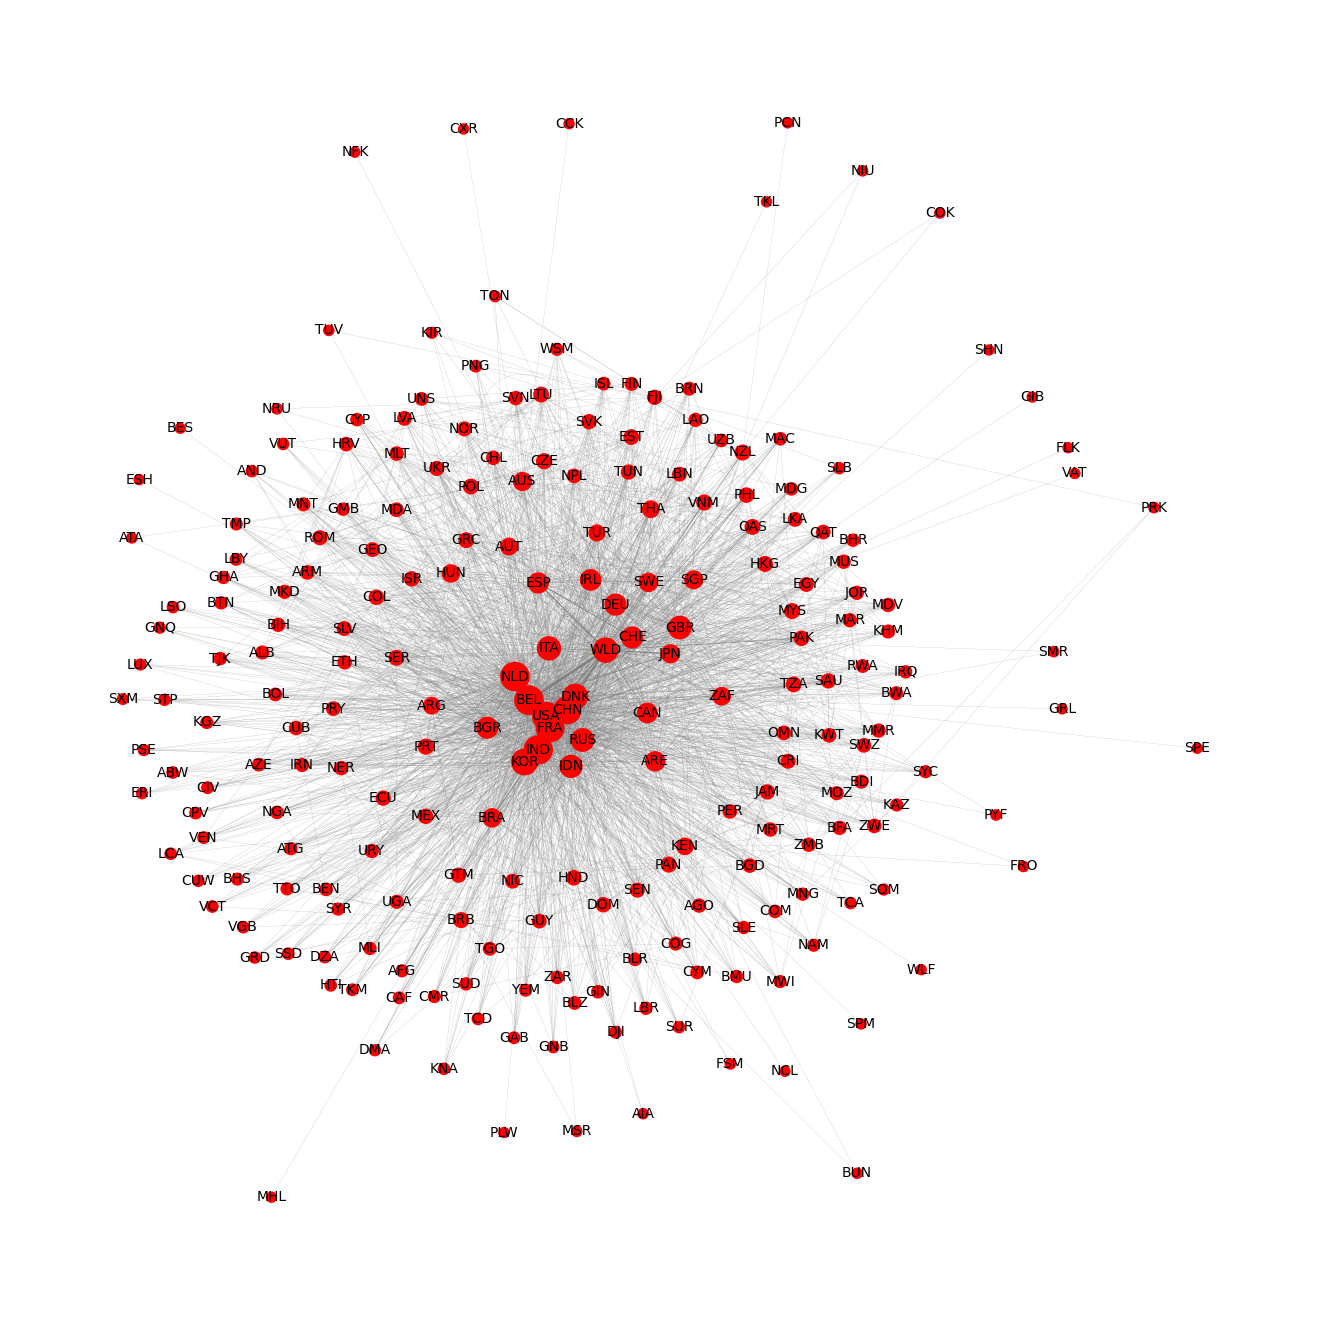

In [56]:

df_2021 = df[df['Year'] == 2021]
G = nx.from_pandas_edgelist(df_2021, "ReporterISO3", "PartnerISO3", edge_attr=True)
G.number_of_nodes()
G.number_of_edges()
plt.figure(figsize=(13, 13))
# node size is proportional to the number of edges
pos = nx.kamada_kawai_layout(G)
# edge width is proportional to the trade value
edges = G.edges(data=True)
weights = [0.1+1e-7*d['TradeValue in 1000 USD'] for (u, v, d) in edges]
# draw the graph with labels and without nodes


nx.draw(
    G,
    with_labels=True,
    pos=pos,
    node_size=[50 + G.degree(n) * 2 for n in G.nodes()],
    font_size=10,
    node_color="red",
    edge_color="grey",
    width=weights
)


# ciekawe informacje
1. rozklad wierzcholkow (sprawdzcic czy siec jest zlozona) 
2. wielkosc swiata - jaka maksymalna droge trzeba przejsc zeby zdobyc okreslony medykament dla kota (najbardziej pesymistyczny przypadek)
3. wierzcholek o najwyzszym stopniu (przez ktore panstwo przechodzi najwiecej medykamentow)
4. mosty - jakie panstwa sa niezbedne zeby zachowac spojnosc wymiany handlowej medykamentow
5. srednia dlugosc najkrotszej sciezki - srednia ilosc krajow przez jakie trzeba przejsc zeby zdobyc medykament dla kota
6. najwieksza klika - najwieksza grupa panstw z ktorych kazde prowadzi wymiane handlowa z kazdym z innych panstw w tej grupie

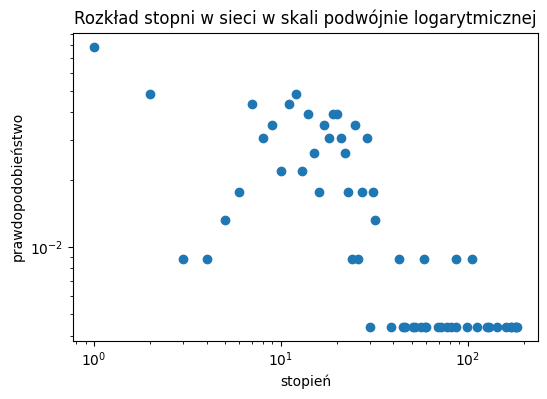

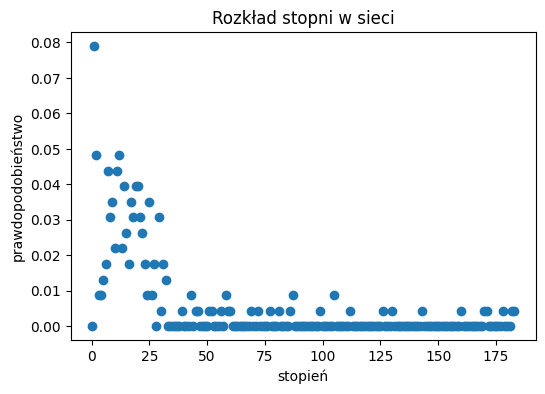

In [57]:
degree_freq = nx.degree_histogram(G)
degree_freq_normalized = [x/sum(degree_freq) for x in degree_freq]
degrees = range(len(degree_freq))
plt.figure(figsize=(6, 4)) 
plt.loglog(degrees, degree_freq_normalized,'o') 
plt.xlabel('stopień')
plt.ylabel('prawdopodobieństwo')
plt.title('Rozkład stopni w sieci w skali podwójnie logarytmicznej')
plt.show()
plt.figure(figsize=(6, 4)) 
plt.plot(degrees, degree_freq_normalized,'o')
plt.xlabel('stopień')
plt.ylabel('prawdopodobieństwo')
plt.title('Rozkład stopni w sieci')
plt.show()

## jak maly jest swiat 
(najdluzsza z najkrotszych drog)

In [58]:
try:

    print(f'Najdluzsza z najkrotszych drog (wielkosc swiata): {nx.diameter(G)}')
except nx.NetworkXError:
    print('Graf nie jest spójny')

Najdluzsza z najkrotszych drog (wielkosc swiata): 4


In [59]:
degrees = nx.degree(G)
degrees = dict(degrees)
degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
degrees[0]
country  = degrees[0][0]
country = CONTRY_CODES[country]
print(f'Najwazniejsze panstwo to {country} z {degrees[0][1]} wspolpracujacymi krajami')

Najwazniejsze panstwo to Belgium z 183 wspolpracujacymi krajami


In [60]:
bridges =[bridge for bridge in  nx.bridges(G)]
unique_nodes = set(CONTRY_CODES[node] for bridge in bridges for node in bridge)
print(f'Jeśli usuniemy jedna z tych {len(unique_nodes)} krajow to graf stanie się niespójny: {unique_nodes}\n')
print(f'Jest to {len(unique_nodes)/len(G.nodes())*100:.0f} % ze wszystkich krajow')

Jeśli usuniemy jedna z tych 29 krajow to graf stanie się niespójny: {'Special Categories', 'New Caledonia', 'Netherlands', 'Christmas Island', 'Denmark', 'Marshall Islands', 'South Africa', 'Norfolk Island', 'Western Sahara', 'Gibraltar', 'Saint Helena', 'France', 'Falkland Island', 'Ireland', 'Greenland', 'Wallis and Futura Isl.', 'Palau', 'Switzerland', 'New Zealand', 'United Kingdom', 'Holy See', 'Australia', 'India', 'Tokelau', 'Cocos (Keeling) Islands', 'Bonaire', 'Pitcairn', 'Saint Pierre and Miquelon', 'Brazil'}

Jest to 13 % ze wszystkich krajow


In [61]:
print(f"srednia dlugosc najkrotszej sciezki miedzy krajami: {nx.average_shortest_path_length(G):.2f}")

srednia dlugosc najkrotszej sciezki miedzy krajami: 2.00


In [62]:
# dlugosc najkrotszej sciezki miedzy krajami w kolejnych latach
for year in df['Year'].unique():
    df_year = df[df['Year'] == year]
    G = nx.from_pandas_edgelist(df_year, "ReporterISO3", "PartnerISO3", edge_attr=True)
    print(f'{year}: {nx.average_shortest_path_length(G):.2f}')
    

2018: 2.00
2019: 2.03
2021: 2.00
2020: 2.02
2017: 2.03


In [63]:
# find clicks
clicks = nx.find_cliques(G)
clicks = list(clicks)
clicks = sorted(clicks, key=lambda x: len(x), reverse=True)
clicks[0]
clicks[0] = [CONTRY_CODES[node] for node in clicks[0]]
print(f'Najwieksza klika to {clicks[0]}')

# create graph where click is a node
clicks = nx.find_cliques(G)
clicks = list(clicks)
clicks = sorted(clicks, key=lambda x: len(x), reverse=True)
clicks = [tuple(click) for click in clicks]
clicks = [tuple([CONTRY_CODES[node] for node in click]) for click in clicks]
names = []

Najwieksza klika to ['Belgium', 'India', 'France', 'Netherlands', 'United States', 'United Kingdom', 'Switzerland', ' World', 'Italy', 'Ireland', 'Canada', 'Denmark', 'Spain', 'Sweden', 'Australia', 'Poland', 'Austria']


In [64]:
# country with most trade value

contry = df.groupby('ReporterISO3').sum().sort_values('TradeValue in 1000 USD', ascending=False).index[0]
country

C:\Users\skibi\AppData\Local\Temp\ipykernel_20340\2076336471.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  contry = df.groupby('ReporterISO3').sum().sort_values('TradeValue in 1000 USD', ascending=False).index[0]


'Belgium'

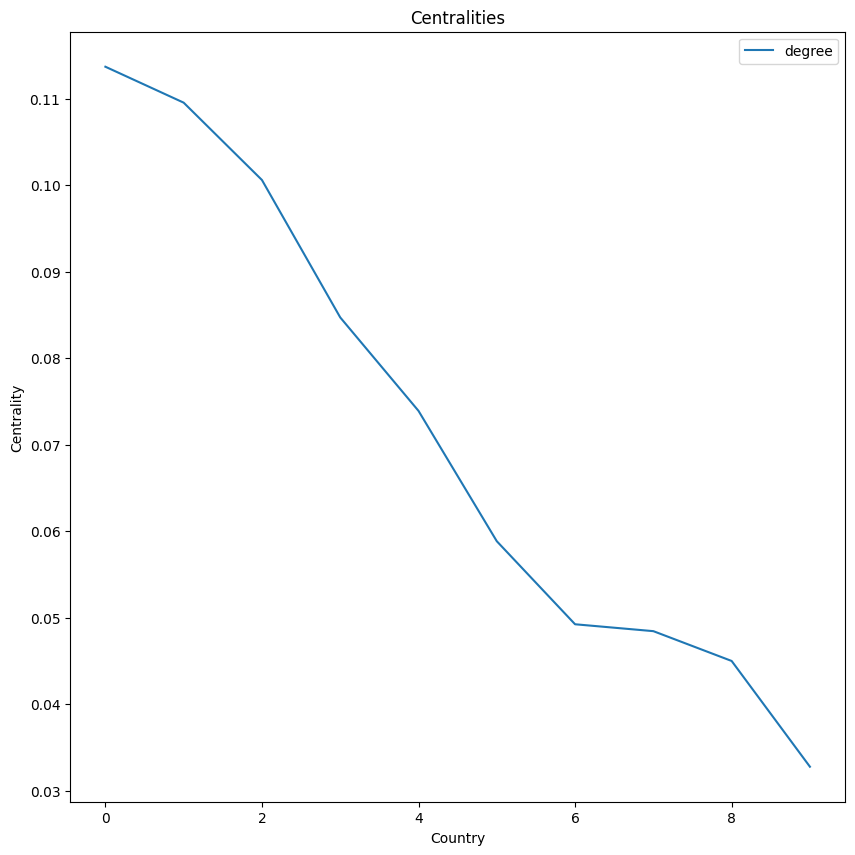

In [65]:
# centralities
data = {}
for year in df['Year'].unique():
    df_year = df[df['Year'] == year]
    G = nx.from_pandas_edgelist(df_year, "ReporterISO3", "PartnerISO3", edge_attr=True)
    data[year] = {}
    centrality = nx.betweenness_centrality(G)
    centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    data[year]['degree'] = centrality


# plot centralities over time
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for centrality in data[2021]:
    ax.plot([x[1] for x in data[2021][centrality]], label=centrality)
ax.set_title('Centralities')
ax.set_xlabel('Country')
ax.set_ylabel('Centrality')
ax.legend()
plt.show()






Counter({1: 16, 9: 15, 7: 14, 15: 13, 10: 13, 6: 13, 8: 9, 2: 9, 23: 8, 17: 8, 12: 8, 5: 8, 13: 7, 18: 6, 16: 6, 4: 6, 3: 6, 11: 5, 19: 4, 14: 4, 28: 3, 71: 2, 64: 2, 37: 2, 30: 2, 22: 2, 20: 2, 177: 1, 174: 1, 173: 1, 150: 1, 126: 1, 122: 1, 118: 1, 99: 1, 96: 1, 89: 1, 85: 1, 83: 1, 78: 1, 75: 1, 67: 1, 62: 1, 58: 1, 49: 1, 46: 1, 43: 1, 42: 1, 40: 1, 39: 1, 32: 1, 27: 1, 26: 1, 25: 1, 21: 1})


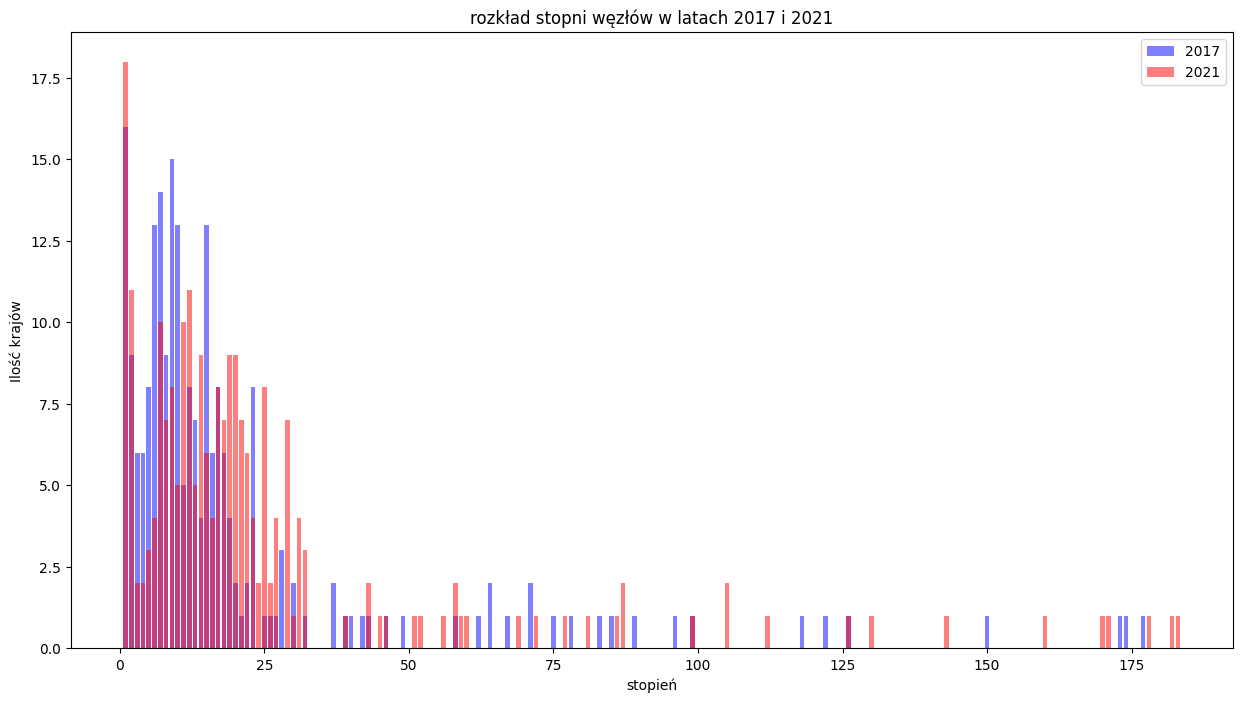

In [68]:
import collections
#degree histogram for 2017 and 2021
df_2017 = df[df['Year'] == 2017]
df_2021 = df[df['Year'] == 2021]

G_2017 = nx.from_pandas_edgelist(df_2017, source='ReporterISO3', target='PartnerISO3',
        edge_attr='TradeValue in 1000 USD', create_using=nx.Graph())
G_2021 = nx.from_pandas_edgelist(df_2021, source='ReporterISO3', target='PartnerISO3',
        edge_attr='TradeValue in 1000 USD', create_using=nx.Graph())

degree_2017 = G_2017.degree()
degree_2021 = G_2021.degree()


degree_2017 = sorted([d for n, d in degree_2017], reverse=True)
degree_2021 = sorted([d for n, d in degree_2021], reverse=True)

#count the number of nodes for each degree
degreeCount_2017 = collections.Counter(degree_2017)
degreeCount_2021 = collections.Counter(degree_2021)
print(degreeCount_2017)
deg_2017, cnt_2017 = zip(*degreeCount_2017.items())
deg_2021, cnt_2021 = zip(*degreeCount_2021.items())

fig = plt.figure(figsize=(15, 8))
plt.bar(deg_2017, cnt_2017, color='blue', label='2017', alpha=0.5)
plt.bar(deg_2021, cnt_2021  ,color='red', label='2021', alpha=0.5)
plt.title('rozkład stopni węzłów w latach 2017 i 2021')
plt.ylabel('Ilość krajów')
plt.xlabel('stopień')
plt.legend()
plt.show()

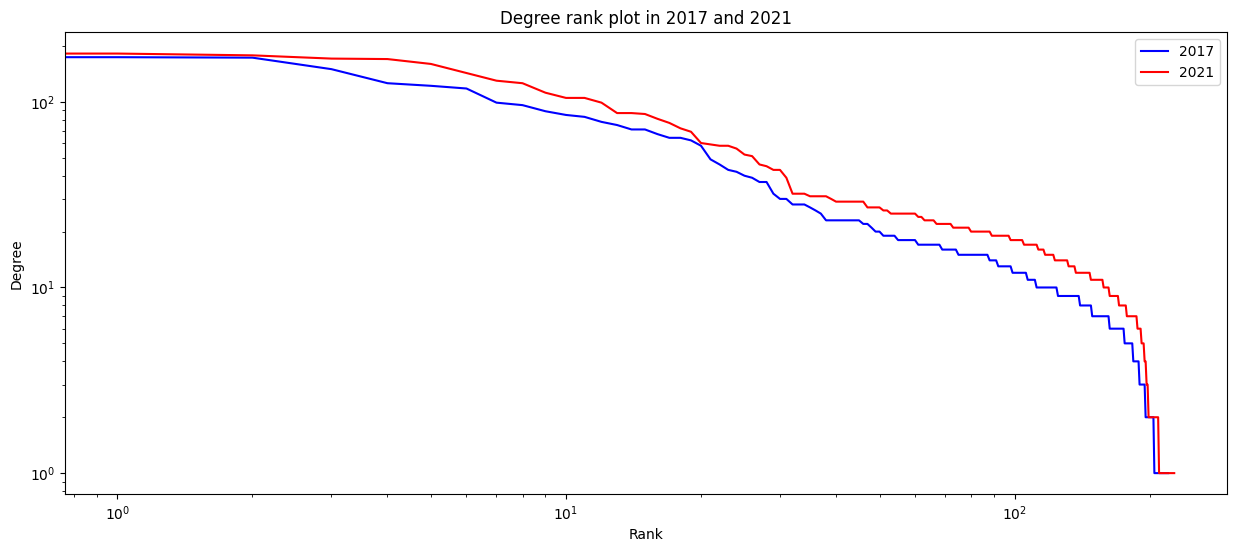

In [69]:
fig = plt.figure(figsize=(15, 6))
plt.plot(degree_2017, color='blue', label='2017')
plt.plot(degree_2021, color='red', label='2021')
plt.xscale('log')
plt.yscale('log')
plt.title('Degree rank plot in 2017 and 2021')
plt.xlabel('Rank')
plt.ylabel('Degree')
plt.legend()
plt.show()
